# NIRC2 Non-Linearity Analysis

Quick non-linearity analysis of the NIRC2 CCD. Data taken from 2019-10-26 UTC, provided by Jim Lyke. There were some suggestions that there might be non-linearity sooner than we expect on NIRC2, so it merited investigating.

In [1]:
import glob
import json

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib_boilerplate import boilerplate
boilerplate.mpl_set_default_font('/Users/jsn/landing/docs/fonts/IBMPlexMono-Regular.ttf')
boilerplate.overwrite_mpl_defaults()

import numpy as np
from numpy.polynomial import Polynomial

from nirc2_nonlinearity_correction import *

In [2]:
def divide_image(n_div, data):
    # divide into a nxn square

    squares = []
    
    sy,sx = data.shape
    
    dy = sy//n_div
    dx = sx//n_div

    for j in range(n_div):
        for i in range(n_div):
            #print('({}, {}) x -> [{}:{}], y -> [{}:{}]'.format(i, j, i*dx, (i+1)*dx, j*dy, (j+1)*dy))
    
            xlo = i*dx
            xhi = (i+1)*dx
            ylo = j*dy
            yhi = (j+1)*dy
    
            squares.append(data[ylo:yhi,xlo:xhi])

    return squares

In [3]:
def reassemble_image(quads):

    bot = np.concatenate((quads[0], quads[1]), axis=1)
    top = np.concatenate((quads[2], quads[3]), axis=1)
    new_data = np.concatenate((bot, top), axis=0)
    
    return new_data

---

Sanity check to check the order of the quadrants we're dividing. Goes lower left, lower right, upper left, upper right.


In [4]:
quad_labels = ['Lower Left', 'Lower Right', 'Upper Left', 'Upper Right']

AOOPSMODE= '2       '           / AO General Ops Mode                            [astropy.io.fits.card]


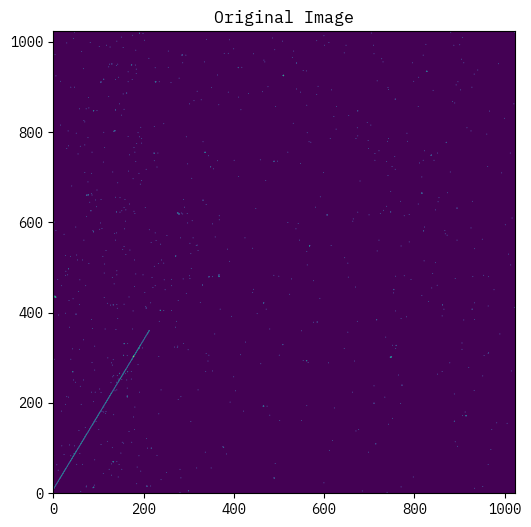

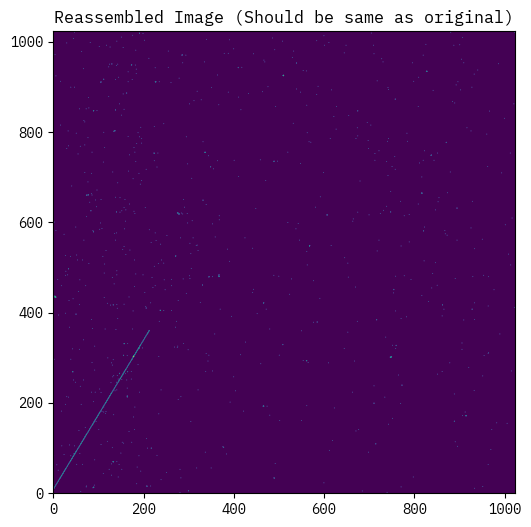

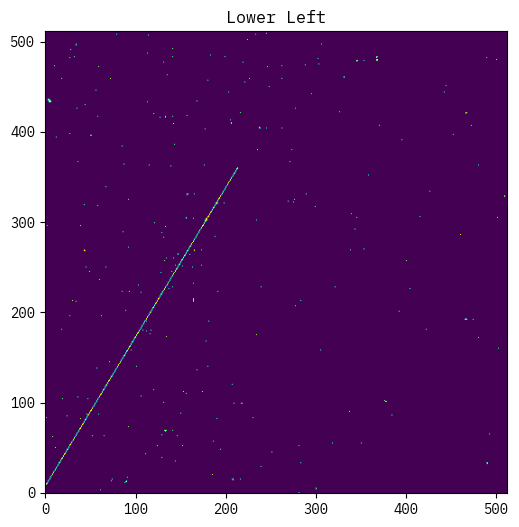

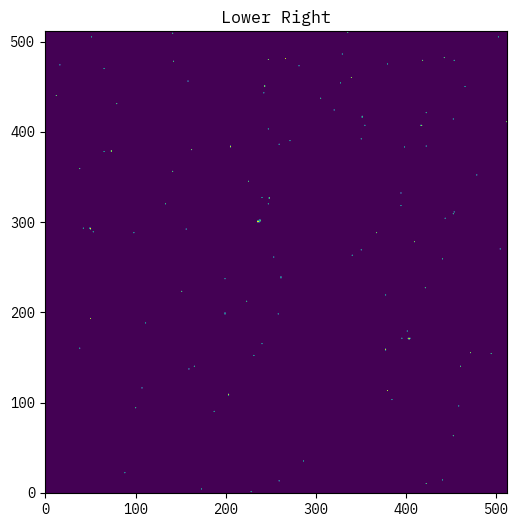

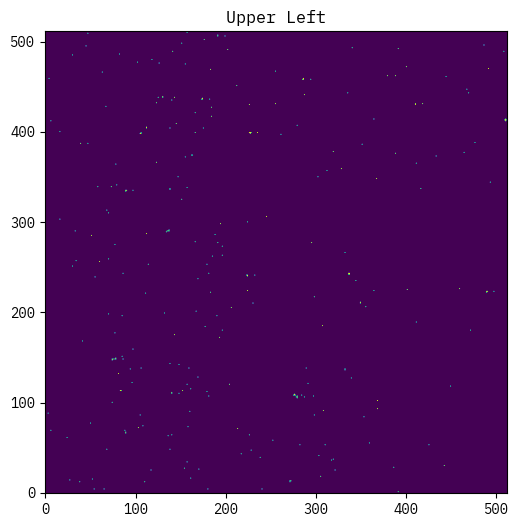

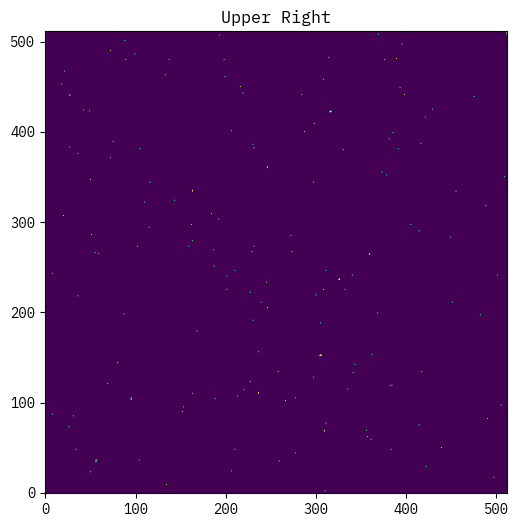

In [5]:
bad_pixel_mask = fits.getdata('nirc2mask.fits')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(bad_pixel_mask)
ax.set_title('Original Image')
plt.show()

quads = divide_image(2, bad_pixel_mask)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(reassemble_image(quads))
ax.set_title('Reassembled Image (Should be same as original)')
plt.show()

for q, ql in zip(quads, quad_labels):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(q)
    ax.set_title(ql)
    plt.show()

---

IMPORTANT NOTE HERE, I divide my reduced images by 4 to get back into units of DN. My reduction pipeline scales to e-/DN

In [6]:
data_folder = '/Users/jsn/landing/data/2019-10-26/reduced/'

data = []
headers = []
for fn in sorted(glob.glob(data_folder+'*.fits')):
    data.append(fits.getdata(fn)/4) # divide by 4 to get back into units of DN
    headers.append(fits.getheader(fn))

bad_pixel_mask = fits.getdata('nirc2mask.fits')

exp_times = np.array([h['ITIME'] for h in headers])

---

Now, calculate all the relevant statistics...

In [7]:

n_div = 2
full_data_mean = []
full_data_std = []
for d in data:
    squares = divide_image(n_div, d)

    means = []
    masked = np.ma.array(d, mask=bad_pixel_mask)

    full_data_mean.append(np.ma.mean(masked))
    full_data_std.append(np.ma.std(masked))

full_data_mean = np.array(full_data_mean)
full_data_std = np.array(full_data_std)

# Plots

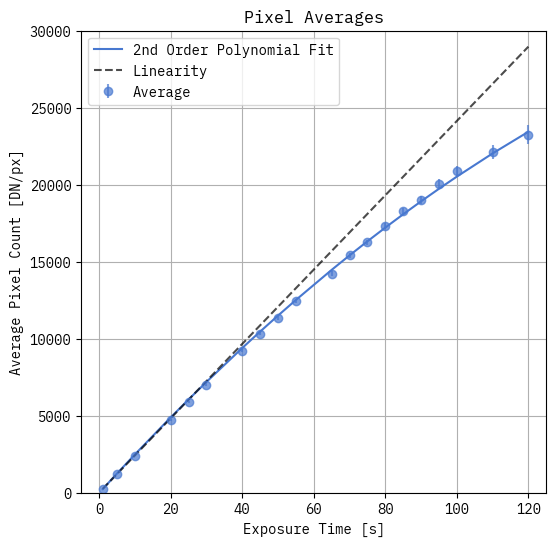

In [8]:
fig, ax = plt.subplots(figsize=(6,6))

ax.errorbar(exp_times, full_data_mean, yerr=full_data_std, marker='o', linestyle='none', label='Average', alpha=0.7)

weights = full_data_std/full_data_mean # higher number = more weight
res = Polynomial.fit(exp_times, full_data_mean, 2, w=weights)
ax.plot(exp_times, np.vectorize(res)(exp_times), linestyle='-', color=ax.get_lines()[-1].get_c(), label='2nd Order Polynomial Fit')

n_fit = 3
weights = full_data_std/full_data_mean # higher number = more weight
line = Polynomial.fit(exp_times[:n_fit], full_data_mean[:n_fit], 1, w=weights[:n_fit])
ax.plot(exp_times, line(exp_times), linestyle='--', color='black', alpha=0.7, label='Linearity')

ax.set_title('Pixel Averages')

ax.set_xlabel('Exposure Time [s]')
ax.set_ylabel('Average Pixel Count [DN/px]')

ax.set_xlim(-5,125)
ax.set_ylim(0,30000)

ax.grid()
ax.legend()

plt.savefig('pixel_averages.png', bbox_inches='tight')
plt.savefig('pixel_averages.pdf', bbox_inches='tight')

plt.show()

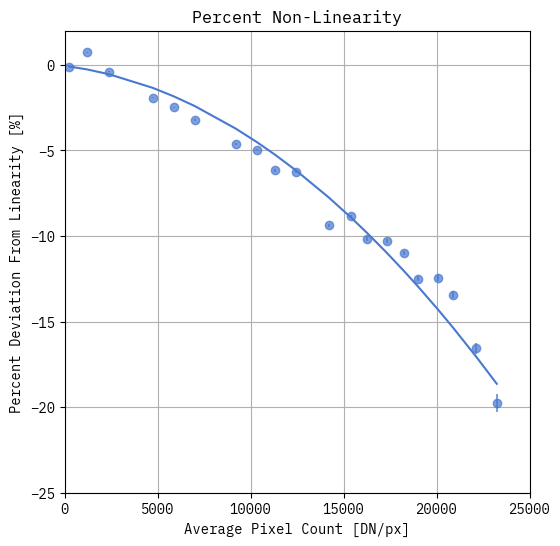

In [9]:
fig, ax = plt.subplots(figsize=(6,6))

expected = line(exp_times)
diff = (full_data_mean - expected) /  expected

weights = full_data_std/full_data_mean # higher number = more weight
nonlinearity_fit = Polynomial.fit(full_data_mean, diff, 2, w=weights)

ax.errorbar(full_data_mean, diff*100, yerr=np.abs(weights*diff*100), marker='o', linestyle='none', alpha=0.7)
ax.plot(full_data_mean, np.vectorize(nonlinearity_fit)(full_data_mean)*100, linestyle='-', color=ax.get_lines()[-1].get_c(), label='2nd Order Polynomial Fit')

ax.set_title('Percent Non-Linearity')

ax.set_xlabel('Average Pixel Count [DN/px]')
ax.set_ylabel('Percent Deviation From Linearity [%]')

ax.set_xlim(0,25000)
ax.set_ylim(-25,2)

ax.grid()

plt.savefig('percent_nonlinearity.png', bbox_inches='tight')
plt.savefig('percent_nonlinearity.pdf', bbox_inches='tight')

plt.show()

---

Make the function that actually corrects for nonlinearity... And by the power of numpy, works on single values and arrays!

---

Sanity check correction...

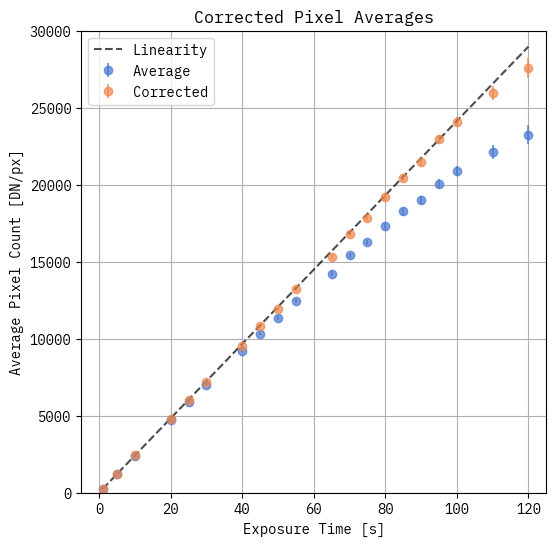

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(exp_times, full_data_mean, yerr=full_data_std, marker='o', linestyle='none', label='Average', alpha=0.7)
ax.errorbar(exp_times, correct_nonlinearity(full_data_mean), yerr=full_data_std, marker='o', linestyle='none', label='Corrected', alpha=0.7)

n_fit = 3
weights = full_data_std/full_data_mean # higher number = more weight
line = Polynomial.fit(exp_times[:n_fit], full_data_mean[:n_fit], 1, w=weights[:n_fit])
ax.plot(exp_times, line(exp_times), linestyle='--', color='black', alpha=0.7, label='Linearity')

ax.set_title('Corrected Pixel Averages')

ax.set_xlabel('Exposure Time [s]')
ax.set_ylabel('Average Pixel Count [DN/px]')

ax.set_xlim(-5,125)
ax.set_ylim(0,30000)

ax.grid()
ax.legend()

plt.savefig('corrected_pixel_averages.png', bbox_inches='tight')
plt.savefig('corrected_pixel_averages.pdf', bbox_inches='tight')

plt.show()

In [11]:
poly = {'mapparm': res.mapparms(), 'coef':tuple(res.coef)}

with open('nirc2_nonlinearity_correction_params.json', 'w') as f:
    f.write(json.dumps(poly))

# Quad Analysis

Divide the image into 4 quadrants and do the same analysis as above separately on each.

Why? Because the readout electronics seem to be tied to 4 quadrants separately.

In [12]:
n_div = 2
bpm_squares = divide_image(n_div, bad_pixel_mask)

quad_data_mean = []
quad_data_std = []
for d in data:
    squares = divide_image(n_div, d)

    means = []
    std = []
    for bpm_sq, sq in zip(bpm_squares,squares):
        masked = np.ma.array(sq, mask=bpm_sq)
        means.append(np.ma.mean(masked))
        std.append(np.ma.std(masked))

    quad_data_mean.append(means)
    quad_data_std.append(std)

quad_data_mean = np.array(quad_data_mean)
quad_data_mean = quad_data_mean.T

quad_data_std = np.array(quad_data_std)
quad_data_std = quad_data_std.T

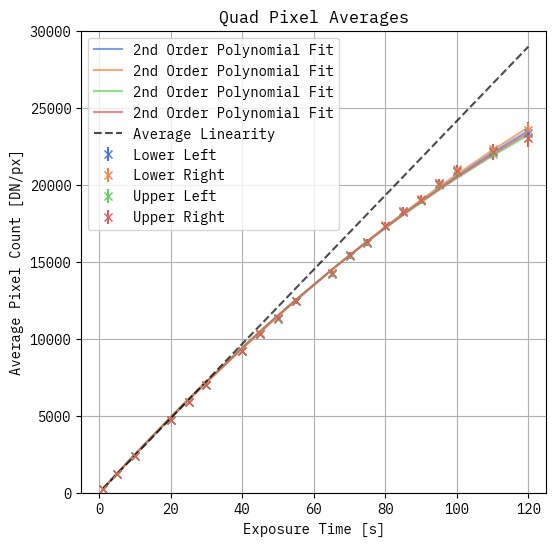

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

lines = []
for mean,std,ql in zip(quad_data_mean,quad_data_std,quad_labels):

    n_fit = 3
    weights = std/mean # higher number = more weight
    line = Polynomial.fit(exp_times[:n_fit], mean[:n_fit], 1, w=weights[:n_fit])
    lines.append(line)

    ax.errorbar(exp_times, mean, yerr=std, marker='x', linestyle='none', label=ql)

    weights = std/mean # higher number = more weight
    res = Polynomial.fit(exp_times, mean, 2, w=weights)
    ax.plot(exp_times, np.vectorize(res)(exp_times), linestyle='-', color=ax.get_lines()[-1].get_c(), alpha=0.7, label='2nd Order Polynomial Fit')

# average all the lines to get the "average" linearity line
avg_line = np.mean(lines)
ax.plot(exp_times, avg_line(exp_times), linestyle='--', color='black', alpha=0.7, label='Average Linearity')

ax.set_title('Quad Pixel Averages')

ax.set_xlabel('Exposure Time [s]')
ax.set_ylabel('Average Pixel Count [DN/px]')

ax.set_xlim(-5,125)
ax.set_ylim(0,30000)

ax.grid()
ax.legend()

plt.savefig('quad_pixel_averages.png', bbox_inches='tight')
plt.savefig('quad_pixel_averages.pdf', bbox_inches='tight')

plt.show()

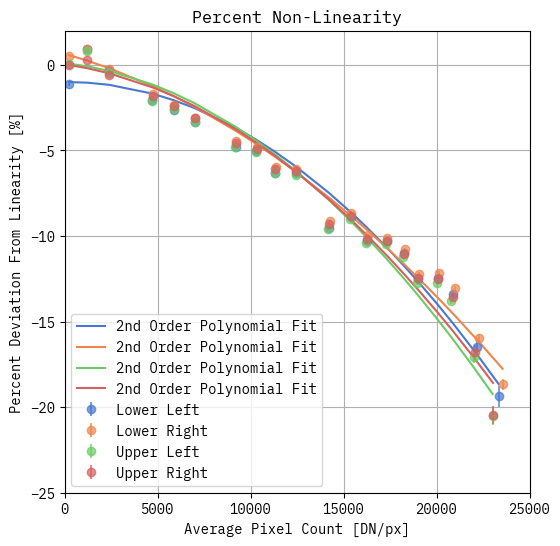

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

quad_nonlinearity_fits = []
for mean,std,ql in zip(quad_data_mean,quad_data_std,quad_labels):
    
    expected = avg_line(exp_times)
    diff = (mean - expected) /  expected
    
    weights = std/mean # higher number = more weight
    nonlinearity_fit = Polynomial.fit(mean, diff, 2, w=weights)
    quad_nonlinearity_fits.append(nonlinearity_fit)
    
    ax.errorbar(mean, diff*100, yerr=np.abs(weights*diff*100), marker='o', linestyle='none', alpha=0.7, label=ql)
    ax.plot(mean, np.vectorize(nonlinearity_fit)(mean)*100, linestyle='-', color=ax.get_lines()[-1].get_c(), label='2nd Order Polynomial Fit')

ax.set_title('Percent Non-Linearity')

ax.set_xlabel('Average Pixel Count [DN/px]')
ax.set_ylabel('Percent Deviation From Linearity [%]')

ax.set_xlim(0,25000)
ax.set_ylim(-25,2)

ax.grid()
ax.legend()

plt.savefig('quad_percent_nonlinearity.png', bbox_inches='tight')
plt.savefig('quad_percent_nonlinearity.pdf', bbox_inches='tight')

plt.show()

In [15]:
quad_poly = []
for res,ql in zip(quad_nonlinearity_fits,quad_labels):
    poly = {'mapparm': res.mapparms(), 'coef':tuple(res.coef), 'label':ql}

    quad_poly.append(poly)

with open('nirc2_quad_nonlinearity_correction_params.json', 'w') as f:
    f.write(json.dumps(quad_poly))

In [16]:
n_div = 2
bpm_squares = divide_image(n_div, bad_pixel_mask)

corrected_quad_data_mean = []
corrected_quad_data_std = []
for d in data:
    d = correct_quad_nonlinearity(d)
    squares = divide_image(n_div, d)

    means = []
    std = []
    for bpm_sq, sq in zip(bpm_squares,squares):
        masked = np.ma.array(sq, mask=bpm_sq)
        means.append(np.ma.mean(masked))
        std.append(np.ma.std(masked))

    corrected_quad_data_mean.append(means)
    corrected_quad_data_std.append(std)

corrected_quad_data_mean = np.array(corrected_quad_data_mean)
corrected_quad_data_mean = corrected_quad_data_mean.T

corrected_quad_data_std = np.array(corrected_quad_data_std)
corrected_quad_data_std = corrected_quad_data_std.T

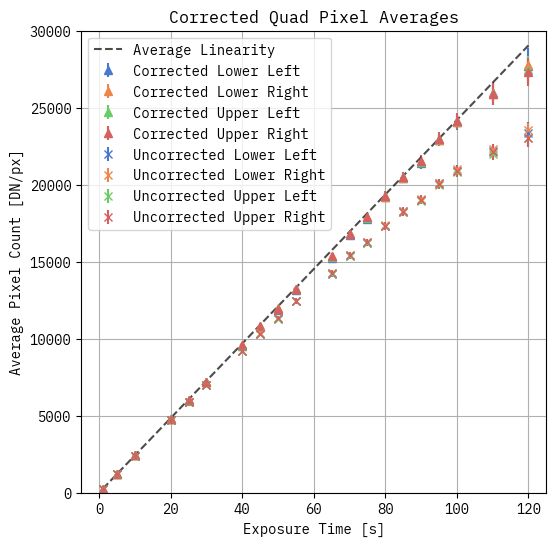

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

lines = []
for mean,std,ql in zip(corrected_quad_data_mean,corrected_quad_data_std,quad_labels):

    n_fit = 3
    weights = std/mean # higher number = more weight
    line = Polynomial.fit(exp_times[:n_fit], mean[:n_fit], 1, w=weights[:n_fit])
    lines.append(line)

    ax.errorbar(exp_times, mean, yerr=std, marker='^', linestyle='none', label='Corrected {}'.format(ql))

plt.gca().set_prop_cycle(None)
for mean,std,ql in zip(quad_data_mean,quad_data_std,quad_labels):

    n_fit = 3
    weights = std/mean # higher number = more weight
    line = Polynomial.fit(exp_times[:n_fit], mean[:n_fit], 1, w=weights[:n_fit])
    lines.append(line)

    ax.errorbar(exp_times, mean, yerr=std, marker='x', linestyle='none', label='Uncorrected {}'.format(ql))
    
# average all the lines to get the "average" linearity line
avg_line = np.mean(lines)
ax.plot(exp_times, avg_line(exp_times), linestyle='--', color='black', alpha=0.7, label='Average Linearity')

ax.set_title('Corrected Quad Pixel Averages')

ax.set_xlabel('Exposure Time [s]')
ax.set_ylabel('Average Pixel Count [DN/px]')

ax.set_xlim(-5,125)
ax.set_ylim(0,30000)

ax.grid()
ax.legend()

plt.savefig('corrected_quad_pixel_averages.png', bbox_inches='tight')
plt.savefig('corrected_quad_pixel_averages.pdf', bbox_inches='tight')

plt.show()